In [1]:
import sys
sys.path.append('/home/jjwhit/rcGAN/')

In [2]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform 
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
from utils.mri import transforms
from mass_map_utils.scripts.ks_utils import backward_model
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours

from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [5]:
#TODO: Step 1: Load model.
torch.set_float32_matmul_precision('medium')

with open('/home/jjwhit/rcGAN/configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_cosmos_new/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [6]:
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

mirrored_vertices = [(longitude * -1, latitude) for longitude, latitude in COSMOS_VERTICES]


In [7]:
from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [8]:
cosmos_shear = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_shear_cropped.npy')
cosmos_shear_tensor = transforms.to_tensor(cosmos_shear)
cosmos_shear_tensor = cosmos_shear_tensor.permute(2, 0, 1)
cosmos_shear_tensor = cosmos_shear_tensor[None,:, :, :].cuda()

In [9]:
cosmos_shear_tensor.size()

torch.Size([1, 2, 300, 300])

In [19]:
#normalized_gamma, mean, std = transforms.normalize_instance(cosmos_shear_tensor)

In [20]:
#gens_mmGAN =  torch.zeros(size=(32,300,300,2)).cuda()

In [21]:
#for  z in range(32):
#    gens_mmGAN[z,:,:,:] =  mmGAN_model.reformat(mmGAN_model.forward(normalized_gamma))


OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 39.39 GiB total capacity; 38.00 GiB already allocated; 18.00 MiB free; 38.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
gens_mmGAN = torch.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_samps_new')

In [11]:
gens_mmGAN.shape

torch.Size([32, 300, 300, 2])

In [12]:
samp_1  = gens_mmGAN[0,:,:,:].cpu().detach().numpy()

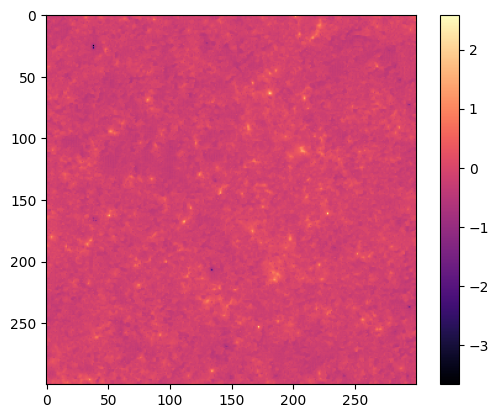

In [14]:
plt.imshow(samp_1[:,:,0], cmap='magma')
plt.colorbar()
plt.show()

In [15]:
avg_mmGAN = torch.mean(gens_mmGAN, dim=0)

In [16]:
avg_mmGAN.shape  #Is this right? I  averaged over the 32 samps?

torch.Size([300, 300, 2])

In [17]:
zfr = mmGAN_model.reformat(cosmos_shear_tensor)

In [18]:
zfr.shape

torch.Size([1, 300, 300, 2])

In [19]:
normalized_gamma, mean, std = transforms.normalize_instance(cosmos_shear_tensor)
normalized_gamma = normalized_gamma.cuda()
mean  = mean.cuda()
std = std.cuda()

In [20]:
np_avgs = {
    'mmGAN': None,
}

np_samps = {
    'mmGAN': [],
}

np_stds = {
    'mmGAN': None,
}

In [21]:
np_zfr = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((zfr * std + mean).cpu())).abs().numpy(), 180)

In [22]:
np_avgs['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN * std + mean).cpu().detach())).abs().numpy(),
    180)

In [23]:
np_avgs['mmGAN'].dtype

dtype('float32')

In [24]:
for z in range(cfg.num_z_test):
    np_samps['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[z] * std + mean).cpu().detach())).abs().numpy(), 180))

np_stds['mmGAN'] = np.std(np.stack(np_samps['mmGAN']), axis=0)

method = 'mmGAN'

In [25]:
np_stds['mmGAN'].shape

(300, 300)

In [26]:
mask =  np.load(
                    '/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True
                ).astype(bool)

In [27]:
contours = find_contours(mask, 0.5)
outer_contour = max(contours, key=lambda x: x.shape[0])

In [28]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

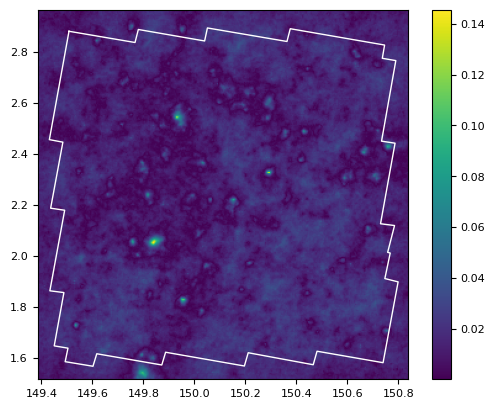

In [30]:
#ra, dec = np.array(COSMOS_VERTICES).T
ra, dec = np.array(mirrored_vertices).T
plt.plot(ra,dec,c='w',lw=1)
plt.imshow(np_avgs[method],extent=get_extend_radec(0.29, 300))
plt.colorbar()
plt.show()

In [31]:
width = 300
resolution = 0.29

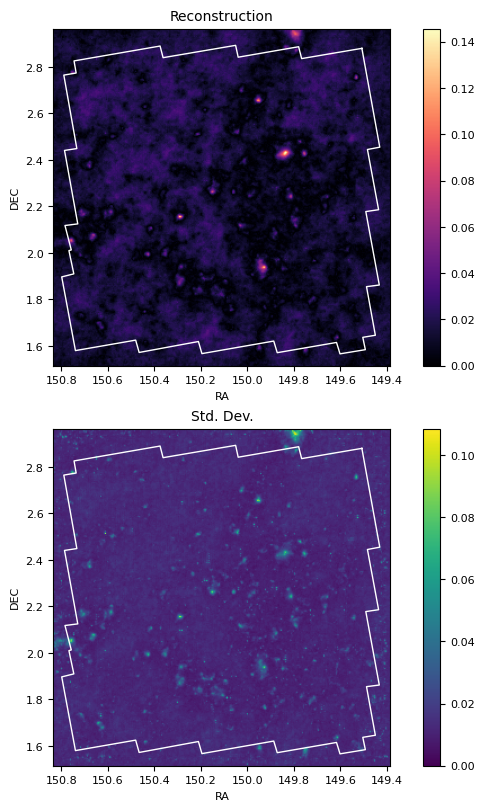

In [32]:
#Fig 1: Global recon, error, std
nrow = 2
ncol = 1
width = 300
resolution = 0.29

fig, axes = plt.subplots(nrow, ncol, figsize=(5,8), constrained_layout=True)

#ra, dec = np.array(COSMOS_VERTICES).T
ra, dec = np.array(mirrored_vertices).T
axes[0].plot(ra,dec,c='w',lw=1)
im1 = axes[0].imshow(np_avgs[method], cmap='magma', vmin=0, vmax=np.max(np_avgs[method]),
                     origin='lower',extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_title('Reconstruction')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')
plt.colorbar(im1, ax=axes[0], shrink=1)

axes[1].plot(ra,dec,c='w',lw=1)
im3 = axes[1].imshow(np_stds[method], cmap='viridis', vmin=0, vmax=np.max(np_stds['mmGAN']), origin='lower',
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_title('Std. Dev.')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')
plt.colorbar(im3, ax=axes[1], shrink=1)

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/cosmos_prelim_results_{fig_count}.png', bbox_inches='tight', dpi=300)

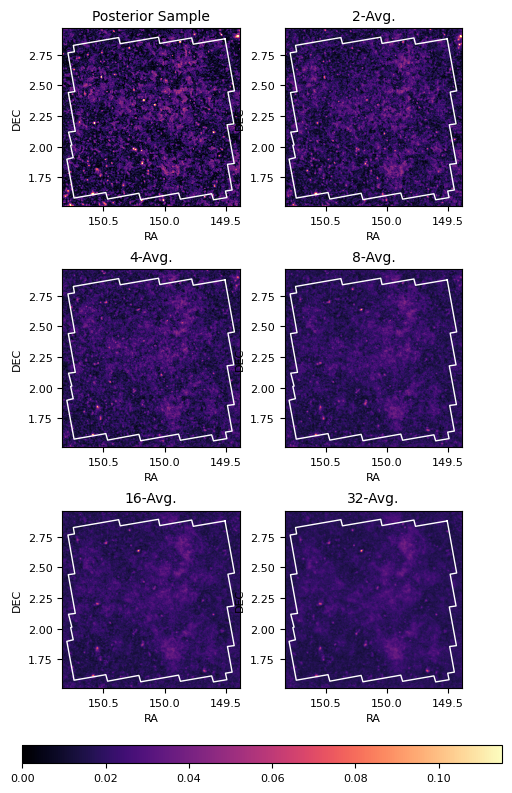

In [31]:
#Plot 7: P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(6,9))

gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.25, hspace=0.25,
                       top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                       left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

vmin = 0
vmax = np.max(np_avgs['mmGAN'])


ax = plt.subplot(gs[0, 0])

avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(1):
    avg += np_samps[method][l]

ax.plot(ra,dec,c='w',lw=1)
im = ax.imshow(avg, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
          extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Posterior Sample')
ax1 = ax

ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(2):
    avg += np_samps[method][l]

avg = avg / 2
ax.plot(ra,dec,c='w',lw=1)
ax.imshow(avg,cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('2-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(4):
    avg += np_samps[method][l]

avg = avg / 4
ax.plot(ra,dec,c='w',lw=1)
ax.imshow(avg, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('4-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(8):
    avg += np_samps[method][l]

avg = avg / 8
ax.plot(ra,dec,c='w',lw=1)
ax.imshow(avg, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('8-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(16):
    avg += np_samps[method][l]

avg = avg / 16
ax.plot(ra,dec,c='w',lw=1)
ax.imshow(avg, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('16-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size))
for l in range(32):
    avg += np_samps[method][l]

avg = avg / 32
ax.plot(ra,dec,c='w',lw=1)
ax.imshow(avg, cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('32-Avg.')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8)


plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/cosmos_P_ascent_{fig_count}.png', bbox_inches='tight', dpi=300)

In [33]:
zoom_length = 80  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]

In [34]:
radec_limits = get_extend_radec(resolution,  width)
ra_length = radec_limits[1] - radec_limits[0]
ra_unit = ra_length/300
dec_length = radec_limits[3] -  radec_limits[2]
dec_unit = dec_length/300

ra_start = radec_limits[0] + ra_unit*zoom_startx
ra_end = radec_limits[0] + ra_unit*(zoom_startx + zoom_length)
dec_start = radec_limits[2] + dec_unit*zoom_starty
dec_end = radec_limits[2] + dec_unit*(zoom_starty + zoom_length)
print(ra_start, ra_end, dec_start, dec_end)

149.82015273077215 150.20709449815536 1.6309019177366488 2.0175169552463066


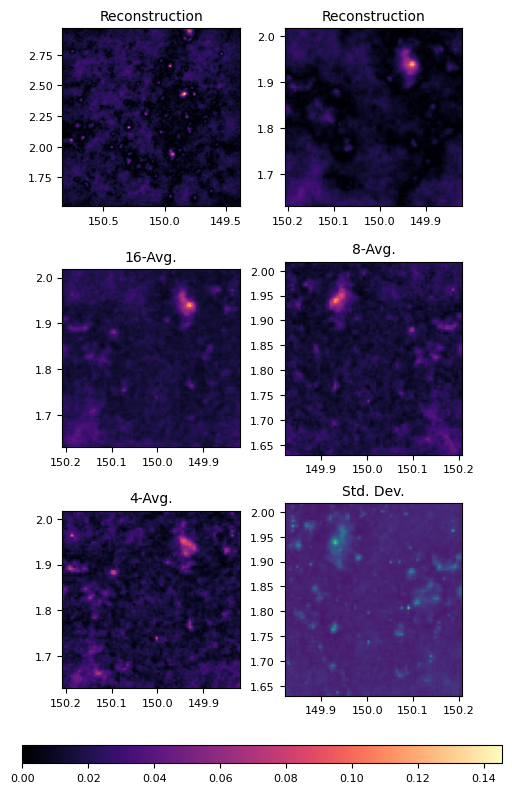

In [35]:
#Plot 3: reconstruction; zoomed reconstruction, 16-, 8-, 4-avg, std. dev.
#TODO: Need to work on axes of this plot.
nrow = 3
ncol = 2

vmin = 0
vmax = np.max(np_avgs[method])

fig = plt.figure(figsize=(6,9))

gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.25, hspace=0.25,
                       top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                       left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_avgs[method], cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('Reconstruction')

ax1 = ax

#rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
#                         edgecolor='r',
#                         facecolor='none')

#ax.add_patch(rect)
ax = plt.subplot(gs[0, 1])
ax.imshow(np_avgs[method][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
          cmap='magma',
          vmin=vmin, vmax=vmax, origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('Reconstruction')

#connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
#                                            [zoom_length, 0], coordsA=ax1.transData,
#                                            coordsB=ax.transData, color='r')
#fig.add_artist(connection_path_1)
#connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [zoom_length, zoom_length],
#                                            coordsA=ax1.transData,
#                                            coordsB=ax.transData, color='r')
#fig.add_artist(connection_path_2)

ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size, cfg.im_size))
for l in range(16):
    avg += np_samps[method][l]
avg = avg / 16

ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
    cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
    extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('16-Avg.')


ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size, cfg.im_size))
for l in range(8):
    avg += np_samps[method][l]

avg = avg / 8
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
    cmap='magma', vmin=vmin, vmax=vmax, origin='lower',
    extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.set_title('8-Avg.')

ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size, cfg.im_size))
for l in range(4):
    avg += np_samps[method][l]

avg = avg / 4
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
    cmap='magma',vmin=vmin, vmax=vmax, origin='lower',
    extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_title('4-Avg.')


ax = plt.subplot(gs[2, 1])
ax.imshow(np_stds[method][zoom_starty:zoom_starty + zoom_length,
          zoom_startx:zoom_startx + zoom_length], cmap='viridis', vmin=0,
          vmax=np.max(np_stds['mmGAN']), origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')

ax.set_title('Std. Dev.')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8)

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/cosmos_zoomed_avg_err_std_{fig_count}.png', bbox_inches='tight', dpi=300)

In [36]:
from scipy.ndimage import gaussian_filter

In [37]:
cosmos_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_mean_hdu.fits')
start_row = (cosmos_dlp.shape[0] - 300) // 2
start_col = (cosmos_dlp.shape[1] - 300) // 2

# Extract the center 300x300 portion
cosmos_dlp_resized = cosmos_dlp[start_row:start_row + 300, start_col:start_col + 300]
std1 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std1.npy', allow_pickle=True
)
std2 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std2.npy', allow_pickle=True
)
D = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_avgs[method], D) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )

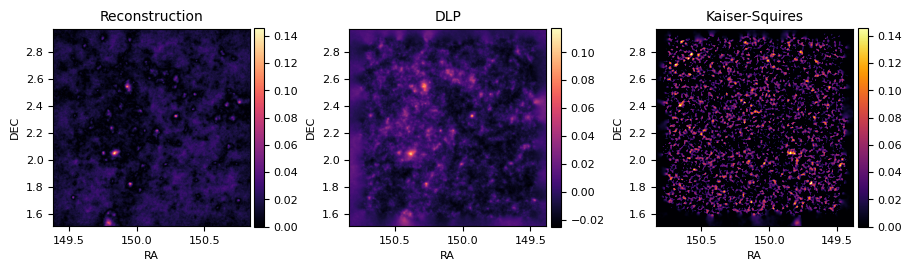

In [39]:
#Plot 6: Kaiser Squires comparison

nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(9,3), constrained_layout=True)

vmin = 0
vmax = np.max(np_avgs[method])

im1 = axes[0].imshow(np_avgs[method], cmap='magma', vmin=vmin, vmax=vmax,
                    extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('Reconstruction')
#axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('DEC')

kappa_sim = backward_model(gamma_sim, D)
im3 = axes[1].imshow(np.rot90(cosmos_dlp_resized), cmap='magma',
                    extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[1].set_title('DLP')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA')
axes[1].set_ylabel('DEC')

#temp_ks = gaussian_filter(kappa_sim,  sigma=(1/.29))
temp_ks = gaussian_filter(kappa_sim,  sigma=1)

im4 = axes[2].imshow(temp_ks.real, cmap='inferno', vmin=vmin, vmax=vmax,
                    extent=get_extend_radec(resolution,  width), aspect='auto') #TODO: Temp
#axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[2].set_title('Kaiser-Squires')
axes[2].invert_xaxis()
axes[2].set_aspect('equal')
axes[2].set_xlabel('RA')
axes[2].set_ylabel('DEC')

cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.02, shrink=0.68)
cbar1.mappable.set_clim(vmin, vmax)
cbar2 = fig.colorbar(im3, ax=axes[1], orientation='vertical', pad=0.02, shrink=0.68)
cbar2.mappable.set_clim(np.min(cosmos_dlp_resized), np.max(cosmos_dlp_resized))
cbar3 = fig.colorbar(im4, ax=axes[2], orientation='vertical', pad=0.02, shrink=0.68)
cbar3.mappable.set_clim(vmin, vmax)

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/cosmos_comparison{fig_count}.png', bbox_inches='tight', dpi=300)

In [35]:
kappa_sim = backward_model(gamma_sim, D)

In [36]:
ks = Gaussian_smoothing(kappa_sim[0], cfg.im_size, 7.0)

In [33]:
cosmos_samps_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_samples_hdu.fits')
start_row = (cosmos_samps_dlp.shape[0] - 300) // 2
start_col = (cosmos_samps_dlp.shape[1] - 300) // 2

# Extract the center 300x300 portion
cosmos_samps_dlp_resized = cosmos_samps_dlp[:,start_row:start_row + 300, start_col:start_col + 300]

In [34]:
cosmos_samps_dlp_resized[0].shape

(300, 300)

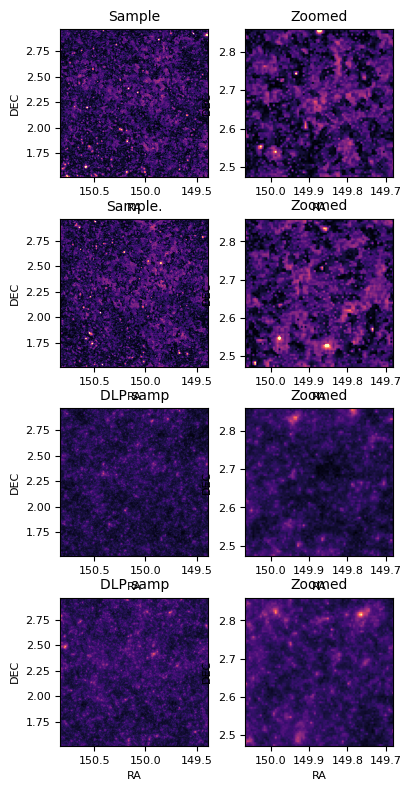

In [80]:
#Sample diversity
nrow = 4
ncol = 2
fig = plt.figure(figsize=(5,9))

vmin_gan = 0
vmax_gan = np.max(np_avgs['mmGAN'])

vmin_dlp = np.min(cosmos_samps_dlp_resized[0])
vmax_dlp = np.max(cosmos_samps_dlp_resized[0])

gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.25, hspace=0.25,
                       top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                       left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])

ax.imshow(np_samps[method][0], cmap='magma', vmin=vmin_gan, vmax=vmax_gan, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Sample')

ax1 = ax

rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                         edgecolor='r',
                         facecolor='none',
                        )

ax.add_patch(rect)
ax = plt.subplot(gs[0, 1])
ax.imshow(np_samps[method][0][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
          cmap='magma',
          vmin=vmin_gan, vmax=vmax_gan, origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC') 
ax.set_title('Zoomed')

#connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
#                                            [0, 0], coordsA=ax1.transData,
#                                            coordsB=ax.transData, color='r')
#fig.add_artist(connection_path_1)
#connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
#                                            coordsA=ax1.transData,
#                                            coordsB=ax.transData, color='r')
#fig.add_artist(connection_path_2)


ax = plt.subplot(gs[1, 0])

ax.imshow(np_samps[method][2], cmap='magma', vmin=vmin_gan, vmax=vmax_gan, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Sample.')

rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                         edgecolor='r',
                         facecolor='none')
ax.add_patch(rect)

ax = plt.subplot(gs[1, 1])
ax.imshow(np_samps[method][2][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
          cmap='magma',
          vmin=vmin_gan, vmax=vmax_gan, origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Zoomed')


ax = plt.subplot(gs[2, 0])
ax.imshow(cosmos_samps_dlp_resized[0], cmap='magma', vmin=vmin_dlp, vmax=vmax_dlp, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('DLP samp')
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                         edgecolor='r',
                         facecolor='none')
ax.add_patch(rect)


ax = plt.subplot(gs[2, 1])
ax.imshow(cosmos_samps_dlp_resized[0][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
          cmap='magma',
          vmin=vmin_dlp, vmax=vmax_dlp, origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Zoomed')


ax = plt.subplot(gs[3, 0])
ax.imshow(cosmos_samps_dlp_resized[2], cmap='magma', vmin=vmin_dlp, vmax=vmax_dlp, origin='lower',
         extent=get_extend_radec(resolution,  width), aspect='auto')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('DLP samp')
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                         edgecolor='r',
                         facecolor='none')
ax.add_patch(rect)


ax = plt.subplot(gs[3, 1])
ax.imshow(cosmos_samps_dlp_resized[2][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length],
          cmap='magma',
          vmin=vmin_dlp, vmax=vmax_dlp, origin='lower',
          extent=[ra_start, ra_end, dec_start, dec_end], aspect='auto')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Zoomed')

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/method_diversity_comparison{fig_count}.png', bbox_inches='tight', dpi=300)

In [44]:
dlp_std = cosmos_samps_dlp_resized[:,...].std(axis=0)

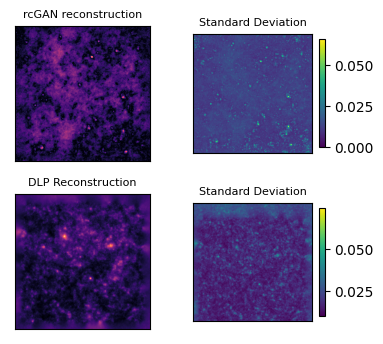

In [45]:
#Comparison plus uncertainty
nrow = 4
ncol = 2
fig = plt.figure(figsize=(5,8))

gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.25, hspace=0.25,
                       top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                       left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])

ax.imshow(np_avgs[method], cmap='magma', vmin=0, vmax=0.7 * np.max(np_avgs['mmGAN']), origin='lower')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
 
ax.set_title('rcGAN reconstruction')

ax1 = ax
ax = plt.subplot(gs[0, 1])
im2 = ax.imshow(np_stds[method], cmap='viridis', vmin=0, vmax=.7 *np.max(np_stds['mmGAN']), origin='lower')
 
ax.set_title('Standard Deviation')
plt.colorbar(im2, shrink=0.8)

ax = plt.subplot(gs[1, 0])

ax.imshow(cosmos_dlp_resized, cmap='magma', vmin=np.min(cosmos_dlp_resized), vmax=np.max(cosmos_dlp_resized), origin='lower')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
 
ax.set_title('DLP Reconstruction')

ax = plt.subplot(gs[1, 1])
im4 = ax.imshow(dlp_std,
          cmap='viridis',
          vmin=np.min(dlp_std),
          vmax=np.max(dlp_std), origin='lower')
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
 
ax.set_title('Standard Deviation')
plt.colorbar(im4, shrink=0.8)

plt.show()
#plt.savefig(f'/share/gpu0/jjwhit/plots/cosmos_training_plots/Std_cosmos_comparison{fig_count}.png', bbox_inches='tight', dpi=300)
plt.close(fig)